# Notebook of Feature Selection of important phenotypes covariables for IBD patients

## Packages

In [ ]:
# Import the required libraries for data analysis and visualization
import pandas as pd # Para manejar dataframes
import numpy as np # Para operaciones matemáticas
import os # Para manejar rutas
import matplotlib.pyplot as plt # Para graficar
import seaborn as sns # Para graficar
import re # Para quitar el patron '_0_0'
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer
from sklearn.impute import IterativeImputer # IterativeImputer
from scipy import stats # Para outliers
import shap # Para SHAP
from sklearn.model_selection import train_test_split # Para dividir el conjunto de datos
from sklearn.ensemble import RandomForestClassifier # Para Random Forest
from sklearn.metrics import classification_report # Para evaluar
from sklearn.preprocessing import LabelEncoder # Para pasar variables categoricas a numericas
import xgboost as xgb # XGboost for classification


## Set paths

In [252]:
# Set the paths
path = "/Users/fjosesala/Documents/GitHub/Horizontal_UKB/main/data/UK_BIOBANK_DATA/" 
path_outputs = "/Users/fjosesala/Documents/GitHub/Horizontal_UKB/phenotype/outputs"

## Charge data

In [ ]:
#Charge the dataframes

# Phenotypes
phenotypes_df = pd.read_csv(os.path.join(path,"phenotype_data.tsv"), sep="\t")

# Phenotype chars
phenotypes_chars_df = pd.read_csv(os.path.join(path,"phenotype_chars.tsv"), sep="\t") #change

# Phenotype keys
phenotypes_keys_df = pd.read_csv(os.path.join(path, 'phenotype_cbkeys.tsv'), sep='\t')

# Olinkdata
ibd0_df= pd.read_csv(os.path.join(path, "ibd0.tsv"),sep="\t")



/var/folders/bf/fdxk2h0901v934ldwnk_10x00000gn/T/ipykernel_16248/1095943101.py:13: DtypeWarning: Columns (1,2,3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  ibd0_df= pd.read_csv(os.path.join(path, "ibd0.tsv"),sep="\t")


## Limpieza

In [186]:
# Quedarse con solo las cohorte 0 de la tabla phenotype 
selected_columns = ['eid'] + [col for col in phenotypes_df.columns if col.endswith('0_0')]
phenotypes_df = phenotypes_df[selected_columns]

# Quitar el patron '_0_0' y el prefijo 'f_' de los nombres de las columnas
phenotypes_df.columns = [re.sub(r'^f_', '', re.sub(r'_0_0$', '', col)) for col in phenotypes_df.columns]

# Cambiar el nombre de las columnas de phenotypes_df segun la columna FieldID de phenotypes_chars_df
rename_dict = dict(zip(phenotypes_chars_df['FieldID'].astype(str), phenotypes_chars_df['Field']))
phenotypes_df.rename(columns=rename_dict, inplace=True)



### Eliminar NAs

In [187]:
# Agregar la columna disease de ibd0 a phenotypes_df
phenotypes_df = phenotypes_df.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

# Ordenar las columnas de phenotypes_df, Disease de segunda columna
phenotypes_df = phenotypes_df[['eid', 'Disease'] + [col for col in phenotypes_df.columns if col not in ['eid', 'Disease']]]

# Drop NA segun la columna Disease
phenotypes_df = phenotypes_df.dropna(subset=['Disease'])

# Drop columnas con mas de 50% de NA
threshold = 0.5 * len(phenotypes_df)
phenotypes_df = phenotypes_df.dropna(thresh=threshold, axis=1)




In [188]:
#Eliminando NAS de todo el dataset
pheno_sinNAs= phenotypes_df.dropna()
pheno_sinNAs

,eid,Disease,Current tobacco smoking,Past tobacco smoking,Smoking/smokers in household,Exposure to tobacco smoke at home,Exposure to tobacco smoke outside home,Cooked vegetable intake,Salad / raw vegetable intake,Fresh fruit intake,...,Ever smoked,Ethnic background,IPAQ activity group,Summed days activity,Summed minutes activity,At or above moderate/vigorous recommendation,At or above moderate/vigorous/walking recommendation,MET minutes per week for walking,MET minutes per week for moderate activity,MET minutes per week for vigorous activity
984,1009851,IBD,0.0,4.0,0.0,0.0,2.0,4.0,3.0,4.0,...,0.0,1003.0,2.0,8.0,180.0,0.0,1.0,2772.0,240.0,0.0
1181,1011821,IBD,0.0,4.0,0.0,0.0,0.0,4.0,4.0,2.0,...,0.0,1001.0,2.0,10.0,110.0,1.0,1.0,330.0,240.0,1440.0
1768,1017690,Control,0.0,4.0,1.0,0.0,0.0,2.0,1.0,2.0,...,0.0,1001.0,1.0,14.0,50.0,1.0,1.0,462.0,840.0,0.0
1856,1018575,Control,0.0,3.0,0.0,0.0,0.0,4.0,1.0,3.0,...,1.0,1001.0,2.0,13.0,380.0,1.0,1.0,2376.0,5040.0,320.0
1989,1019905,Control,0.0,4.0,0.0,0.0,0.0,2.0,2.0,1.0,...,0.0,1001.0,1.0,10.0,150.0,1.0,1.0,198.0,1920.0,240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499951,6000162,Control,0.0,1.0,0.0,0.0,0.0,2.0,3.0,7.0,...,1.0,1001.0,1.0,7.0,30.0,0.0,1.0,693.0,0.0,0.0
500086,6001510,Control,0.0,2.0,0.0,0.0,0.0,3.0,6.0,2.0,...,1.0,1001.0,1.0,6.0,60.0,0.0,1.0,495.0,0.0,240.0
500822,6008871,Control,0.0,4.0,0.0,0.0,0.0,3.0,4.0,2.0,...,0.0,1001.0,1.0,12.0,135.0,1.0,1.0,924.0,720.0,560.0
501053,6011186,IBD,0.0,3.0,1.0,0.0,0.0,1.0,1.0,3.0,...,1.0,1001.0,1.0,7.0,50.0,0.0,1.0,594.0,80.0,0.0


### Imputar variable por variable

In [189]:
# Ver valores unicos de cada columna
for col in phenotypes_df.columns:
    print(f"{col}: {phenotypes_df[col].unique()[:10]}")  # Muestra hasta 10 valores únicos por columna
    print("-" * 40)

eid: [1000298 1000767 1000952 1001301 1001358 1001662 1002418 1002677 1002943
 1002990]
----------------------------------------
Disease: ['Control' 'IBD' 'CD' 'UC']
----------------------------------------
Current tobacco smoking: [ 0.  1.  2. nan -3.]
----------------------------------------
Past tobacco smoking: [ 2.  4.  1.  3. nan -3.]
----------------------------------------
Smoking/smokers in household: [ 0.  1. nan  2. -3.]
----------------------------------------
Exposure to tobacco smoke at home: [ 0. -1.  1. nan 16.  2. 12. 21.  7. 40.]
----------------------------------------
Exposure to tobacco smoke outside home: [ 0. -1.  1. nan  2.  8.  5.  4.  3.  6.]
----------------------------------------
Cooked vegetable intake: [  6.   3.  -1.   2.   5.  10.   1.   4. -10.   7.]
----------------------------------------
Salad / raw vegetable intake: [  3.  -1. -10.   1.   0.   2.   5.  12.   4.   6.]
----------------------------------------
Fresh fruit intake: [  3.   2. -10.   0. 

In [190]:
# Ver la moda de cada columna por grupo de 'Disease'
for col in phenotypes_df.columns:
    if col not in ['eid', 'Disease']:
        moda = phenotypes_df.groupby('Disease')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        print(f"Moda de '{col}' por grupo de 'Disease':")
        print(moda)
        print("-" * 40)

Moda de 'Current tobacco smoking' por grupo de 'Disease':
Disease
CD         0.0
Control    0.0
IBD        0.0
UC         0.0
Name: Current tobacco smoking, dtype: float64
----------------------------------------
Moda de 'Past tobacco smoking' por grupo de 'Disease':
Disease
CD         4.0
Control    4.0
IBD        4.0
UC         4.0
Name: Past tobacco smoking, dtype: float64
----------------------------------------
Moda de 'Smoking/smokers in household' por grupo de 'Disease':
Disease
CD         0.0
Control    0.0
IBD        0.0
UC         0.0
Name: Smoking/smokers in household, dtype: float64
----------------------------------------
Moda de 'Exposure to tobacco smoke at home' por grupo de 'Disease':
Disease
CD         0.0
Control    0.0
IBD        0.0
UC         0.0
Name: Exposure to tobacco smoke at home, dtype: float64
----------------------------------------
Moda de 'Exposure to tobacco smoke outside home' por grupo de 'Disease':
Disease
CD         0.0
Control    0.0
IBD        0.

In [191]:
# Imputación categórica estratificada por clase multinomial,
# Imputar NA en cada columna (excepto eid y Disease) por la moda de los grupos 'Disease'
def impute(df):
    df = df.copy()
    for col in df.columns:
        if col not in ['eid', 'Disease']:
            modas = df.groupby('Disease')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
            df[col] = df.apply(
                lambda row: modas[row['Disease']] if pd.isna(row[col]) else row[col], axis=1
            )
    return df


In [192]:
phenotypes_df_imputed = impute(phenotypes_df)

In [193]:
phenotypes_df_imputed["Condition"] = phenotypes_df_imputed["Disease"].apply(lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control")

# Ordenar las columnas de phenotypes_df, Condition de segunda columna
phenotypes_df_imputed = phenotypes_df_imputed[['eid', 'Disease' ,"Condition"] + [col for col in phenotypes_df_imputed.columns if col not in ['eid', 'Disease' , "Condition"]]]


In [194]:
phenotypes_df_imputed

,eid,Disease,Condition,Current tobacco smoking,Past tobacco smoking,Smoking/smokers in household,Exposure to tobacco smoke at home,Exposure to tobacco smoke outside home,Cooked vegetable intake,Salad / raw vegetable intake,...,Ever smoked,Ethnic background,IPAQ activity group,Summed days activity,Summed minutes activity,At or above moderate/vigorous recommendation,At or above moderate/vigorous/walking recommendation,MET minutes per week for walking,MET minutes per week for moderate activity,MET minutes per week for vigorous activity
28,1000298,Control,Control,0.0,2.0,0.0,0.0,0.0,6.0,3.0,...,1.0,5.0,2.0,16.0,70.0,1.0,1.0,396.0,600.0,800.0
75,1000767,IBD,IBD,0.0,4.0,0.0,0.0,0.0,3.0,3.0,...,0.0,1001.0,1.0,10.0,70.0,1.0,1.0,297.0,600.0,160.0
94,1000952,Control,Control,0.0,4.0,1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,3001.0,2.0,7.0,60.0,1.0,1.0,1386.0,0.0,0.0
129,1001301,Control,Control,0.0,1.0,0.0,0.0,0.0,3.0,-10.0,...,1.0,5.0,2.0,7.0,60.0,1.0,1.0,1386.0,0.0,0.0
134,1001358,Control,Control,0.0,3.0,0.0,0.0,1.0,3.0,1.0,...,1.0,1001.0,1.0,5.0,130.0,0.0,1.0,396.0,480.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502091,6021563,Control,Control,0.0,4.0,0.0,0.0,0.0,3.0,1.0,...,0.0,1001.0,2.0,7.0,60.0,1.0,1.0,1386.0,0.0,0.0
502101,6021667,Control,Control,0.0,4.0,1.0,0.0,0.0,2.0,2.0,...,0.0,1001.0,0.0,2.0,15.0,0.0,0.0,99.0,0.0,0.0
502123,6021888,Control,Control,0.0,4.0,0.0,0.0,3.0,5.0,3.0,...,0.0,1001.0,2.0,7.0,60.0,1.0,1.0,1386.0,0.0,0.0
502126,6021914,Control,Control,0.0,4.0,0.0,0.0,0.0,2.0,2.0,...,0.0,1001.0,2.0,7.0,60.0,1.0,1.0,1386.0,0.0,0.0


### Transformar
Categoricas pasarlas a one-hot encoding,

Ordinales pasarlas a numeros

Numericas limpiar


In [195]:
# Quitar el sufijo '.0' de la columna Coding en phenotypes_chars_df, y pasar a str ambas tablas
phenotypes_chars_df['Coding'] = phenotypes_chars_df['Coding'].astype(str).str.replace(r'\.0$', '', regex=True)
phenotypes_keys_df['coding_name'] = phenotypes_keys_df['coding_name'].astype(str).str.replace(r'\.0$', '', regex=True)


In [196]:
# Dividir el df, en numericos y categoricos
# Lista de columnas numéricas a extraer
numeric_cols = [
    "Exposure to tobacco smoke at home",
    "Exposure to tobacco smoke outside home",
    "Cooked vegetable intake",
    "Salad / raw vegetable intake",
    "Fresh fruit intake",
    "Dried fruit intake",
    "Bread intake",
    "Cereal intake",
    "Tea intake",
    "Water intake",
    "Average weekly red wine intake",
    "Average weekly champagne plus white wine intake",
    "Average weekly beer plus cider intake",
    "Average weekly spirits intake",
    "Average weekly fortified wine intake",
    "Summed days activity",
    "Summed minutes activity",
    "MET minutes per week for walking",
    "MET minutes per week for moderate activity",
    "MET minutes per week for vigorous activity"
]

# Generar df de variables numericas
pheno_numeric = phenotypes_df_imputed[['eid'] + [col for col in numeric_cols if col in phenotypes_df_imputed.columns]].copy()

#Generar df de variables categoricas
pheno_categoric = phenotypes_df_imputed.drop(columns=[col for col in numeric_cols if col in phenotypes_df_imputed.columns]) 

In [197]:
pheno_categoric_mapped = pheno_categoric.copy()

def mapear(nombre):
    # Mapear numeros de phenotypes_df_imputed a texto 
    # 1. Obtener el nombre exacto de la columna
    col_name = nombre
    
    # 2. Buscar el código 'coding' asociado en phenotypes_chars_df
    coding_code = phenotypes_chars_df.loc[phenotypes_chars_df['Field'] == col_name, 'Coding'].values[0]

    # 3. Crear el diccionario de mapeo code->meaning desde phenotypes_keys_df
    mapping = phenotypes_keys_df.loc[phenotypes_keys_df['coding_name'] == coding_code, ['code', 'meaning']]
    code_to_meaning = dict(zip(mapping['code'], mapping['meaning']))

    # 4. Reemplazar en la columna original
    pheno_categoric_mapped[col_name] = pheno_categoric_mapped[col_name].map(code_to_meaning)

In [198]:
# Mapear todas las columnas categóricas a texto usando la función mapear
for colname in pheno_categoric_mapped.columns:
    if colname not in ['eid', 'Disease', 'Condition']:
        mapear(colname)

#### Numericas


In [199]:
#Mapear segun Characteristics df
#-10 menos de una unidad
#-3 no quiere responder
#-1 no sabe 

# Mapear -10 a 0.5 y -1/-3 a NaN, excluyendo la columna 'eid'
for col in pheno_numeric.columns:
    if col != 'eid':
        pheno_numeric[col] = pheno_numeric[col].replace(-10, 0.5)
        pheno_numeric[col] = pheno_numeric[col].replace([-1, -3], np.nan)

pheno_numeric= pheno_numeric.dropna()
pheno_numeric


,eid,Exposure to tobacco smoke at home,Exposure to tobacco smoke outside home,Cooked vegetable intake,Salad / raw vegetable intake,Fresh fruit intake,Dried fruit intake,Bread intake,Cereal intake,Tea intake,...,Average weekly red wine intake,Average weekly champagne plus white wine intake,Average weekly beer plus cider intake,Average weekly spirits intake,Average weekly fortified wine intake,Summed days activity,Summed minutes activity,MET minutes per week for walking,MET minutes per week for moderate activity,MET minutes per week for vigorous activity
28,1000298,0.0,0.0,6.0,3.0,3.0,1.0,10.0,7.0,2.0,...,6.0,1.0,1.0,0.0,0.0,16.0,70.0,396.0,600.0,800.0
75,1000767,0.0,0.0,3.0,3.0,2.0,0.0,10.0,4.0,1.0,...,4.0,2.0,1.0,0.0,0.0,10.0,70.0,297.0,600.0,160.0
129,1001301,0.0,0.0,3.0,0.5,0.5,0.5,2.0,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,7.0,60.0,1386.0,0.0,0.0
134,1001358,0.0,1.0,3.0,1.0,2.0,0.0,20.0,3.0,5.0,...,2.0,2.0,3.0,2.0,0.0,5.0,130.0,396.0,480.0,80.0
165,1001662,0.0,1.0,2.0,0.0,0.0,0.0,2.0,5.0,10.0,...,0.0,0.0,9.0,0.0,0.0,8.0,145.0,891.0,200.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502091,6021563,0.0,0.0,3.0,1.0,2.0,0.0,6.0,7.0,3.0,...,0.0,1.0,0.0,0.0,0.0,7.0,60.0,1386.0,0.0,0.0
502101,6021667,0.0,0.0,2.0,2.0,1.0,0.0,12.0,7.0,2.0,...,12.0,4.0,2.0,1.0,1.0,2.0,15.0,99.0,0.0,0.0
502123,6021888,0.0,3.0,5.0,3.0,3.0,1.0,1.0,7.0,0.0,...,2.0,0.0,0.0,3.0,0.0,7.0,60.0,1386.0,0.0,0.0
502126,6021914,0.0,0.0,2.0,2.0,6.0,0.0,5.0,7.0,7.0,...,6.0,9.0,1.0,4.0,0.0,7.0,60.0,1386.0,0.0,0.0


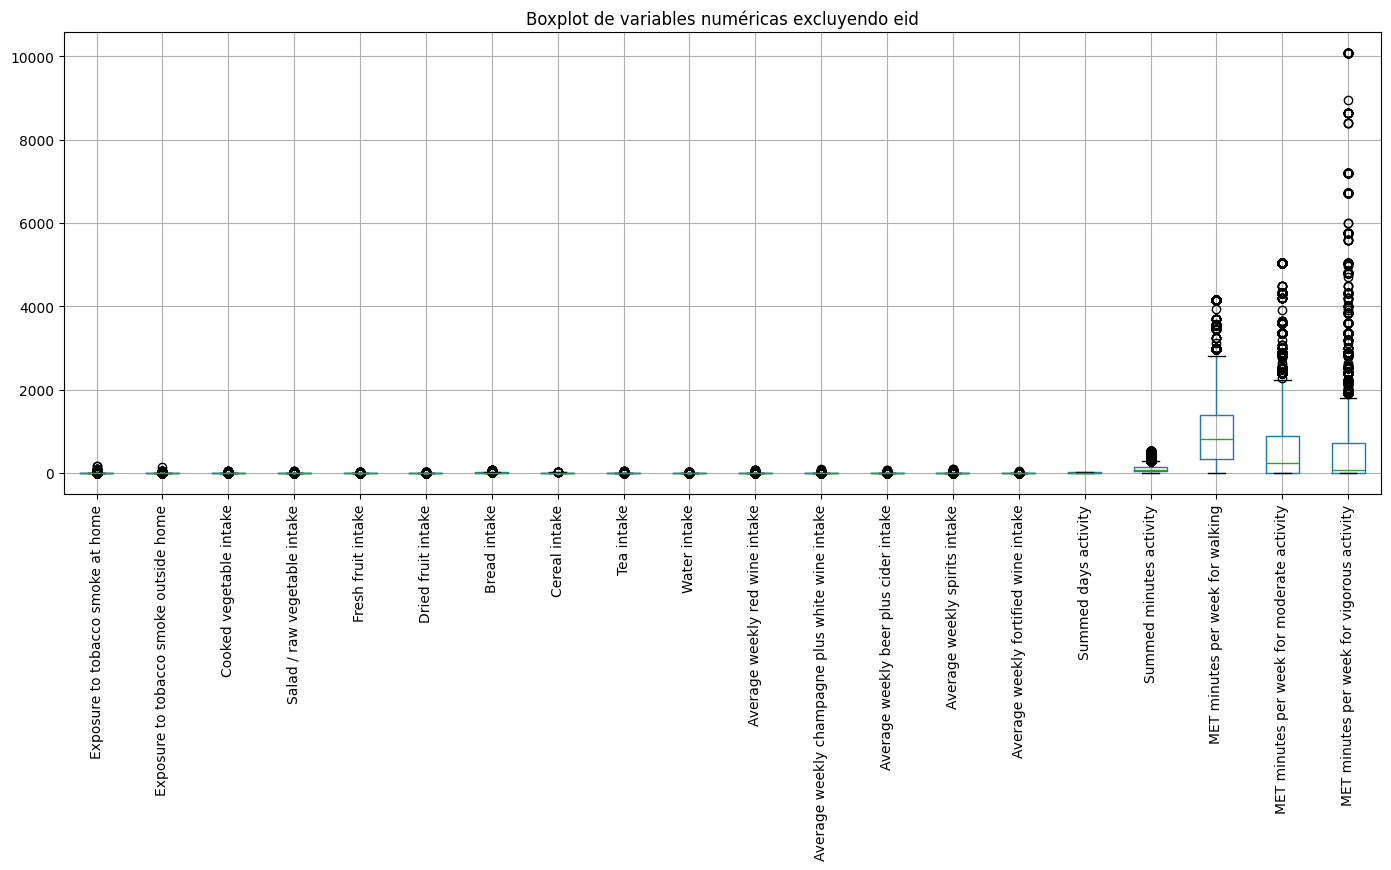

In [200]:
# graficar para ver outliers

# Seleccionar todas las columnas excepto 'eid'
cols_to_plot = pheno_numeric.drop(columns=['eid'])

# Boxplot 
cols_to_plot.boxplot(figsize=(17,6))
plt.title('Boxplot de variables numéricas excluyendo eid')
plt.xticks(rotation=90)
plt.show()

In [201]:
pheno_numeric.dtypes
pheno_numeric['eid'] = pheno_numeric['eid'].astype(str)

In [202]:
#Eliminar outiliers
def remove_outliers(df, id_col='eid', lower=0.05, upper=0.95, drop_rows=True):
    """
    Elimina outliers del DataFrame basado en percentiles columna por columna.
    
    Parámetros:
        df (pd.DataFrame): El DataFrame original.
        id_col (str): Nombre de la columna categórica que no se debe procesar.
        lower (float): Percentil inferior (por defecto 0.05).
        upper (float): Percentil superior (por defecto 0.95).
        drop_rows (bool): Si True, elimina filas con outliers. 
                          Si False, reemplaza outliers por NaN.
                          
    Retorna:
        pd.DataFrame: DataFrame sin outliers.
    """
    df = df.copy()
    
    # Asegurarse de que id_col esté presente
    if id_col not in df.columns:
        raise ValueError(f"La columna '{id_col}' no está en el DataFrame.")

    # Extraer columna ID
    id_series = df[[id_col]].astype(str)

    
    # Filtrar solo columnas numéricas
    numeric_df = df.select_dtypes(include=[np.number]).copy()
    
    # Calcular percentiles
    q_low = numeric_df.quantile(lower)
    q_high = numeric_df.quantile(upper)
    
    # Crear máscara booleana
    mask = (numeric_df >= q_low) & (numeric_df <= q_high)
    
    if drop_rows:
        filtered_numeric = numeric_df[mask.all(axis=1)]
        id_filtered = id_series.loc[filtered_numeric.index]
        return pd.concat([id_filtered, filtered_numeric], axis=1)
    else:
        clipped_numeric = numeric_df.mask(~mask, np.nan)
        return pd.concat([id_series, clipped_numeric], axis=1)


pheno_numeric_noOutliers=remove_outliers(pheno_numeric,id_col='eid', lower=0.05, upper=0.95, drop_rows=False)




In [203]:
#Escalar
from sklearn.preprocessing import StandardScaler

def scale_numeric_columns(df, id_col='eid'):
    """
    Escala las columnas numéricas del DataFrame, excluyendo la columna id_col.

    Parámetros:
        df (pd.DataFrame): DataFrame a escalar.
        id_col (str): Nombre de la columna de identificación (no se escala).

    Retorna:
        pd.DataFrame: DataFrame con columnas numéricas escaladas y id_col intacta.
    """
    df = df.copy()

    if id_col not in df.columns:
        raise ValueError(f"La columna '{id_col}' no está en el DataFrame.")

    # Separar columna ID
    id_series = df[[id_col]].astype(str)

    # Seleccionar columnas numéricas
    numeric_df = df.drop(columns=[id_col]).select_dtypes(include=[np.number])

    # Escalar
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(numeric_df)
    scaled_df = pd.DataFrame(scaled_array, columns=numeric_df.columns, index=numeric_df.index)

    # Concatenar columna ID y columnas escaladas
    return pd.concat([id_series, scaled_df], axis=1)

pheno_numeric_scaled=scale_numeric_columns(pheno_numeric_noOutliers)

In [204]:
#Estandarizar

def scale_numeric_columns(df, id_col='eid'):
    """
    Escala columnas numéricas con StandardScaler, dejando la columna id_col sin cambios y en string.

    Parámetros:
        df (pd.DataFrame): DataFrame con datos.
        id_col (str): Nombre de la columna categórica a preservar (ej. 'eid').

    Retorna:
        pd.DataFrame: DataFrame con columnas numéricas escaladas y id_col como string.
    """
    df = df.copy()

    # Convertir id_col a string
    id_series = df[[id_col]].astype(str)

    # Seleccionar solo columnas numéricas excepto id_col
    numeric_df = df.drop(columns=[id_col]).select_dtypes(include=[np.number])

    # Escalar columnas numéricas
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(numeric_df)
    scaled_df = pd.DataFrame(scaled_array, columns=numeric_df.columns, index=numeric_df.index)

    # Concatenar columna id_col y columnas escaladas
    return pd.concat([id_series, scaled_df], axis=1)
    
    
pheno_numeric_standard=scale_numeric_columns(pheno_numeric_scaled)
pheno_numeric_standard

,eid,Exposure to tobacco smoke at home,Exposure to tobacco smoke outside home,Cooked vegetable intake,Salad / raw vegetable intake,Fresh fruit intake,Dried fruit intake,Bread intake,Cereal intake,Tea intake,...,Average weekly red wine intake,Average weekly champagne plus white wine intake,Average weekly beer plus cider intake,Average weekly spirits intake,Average weekly fortified wine intake,Summed days activity,Summed minutes activity,MET minutes per week for walking,MET minutes per week for moderate activity,MET minutes per week for vigorous activity
28,1000298,0.0,-0.396898,NaN,0.715575,0.715098,0.417313,-0.223232,1.011390,-0.467053,...,1.294574,-0.133118,-0.081283,-0.442226,-0.200812,1.617416,-0.514070,-0.831161,0.061621,0.729971
75,1000767,0.0,-0.396898,0.416371,0.715575,-0.085402,-0.682296,-0.223232,-0.120292,-0.923759,...,0.639093,0.320040,-0.081283,-0.442226,-0.200812,0.035016,-0.514070,-0.973782,0.061621,-0.379363
129,1001301,0.0,-0.396898,0.416371,-1.025108,-1.286154,-0.132491,-1.487049,-1.440588,-0.923759,...,-0.671869,-0.586276,-0.530682,-0.442226,-0.200812,-0.756184,-0.664278,0.595050,-0.728651,-0.656697
134,1001358,0.0,1.840566,0.416371,-0.676971,-0.085402,-0.682296,1.356539,-0.497519,0.903065,...,-0.016388,0.320040,0.817514,1.122832,-0.200812,-1.283651,0.387175,-0.831161,-0.096434,-0.518030
165,1001662,0.0,1.840566,-0.522908,-1.373244,-1.686404,-0.682296,-1.487049,0.256935,NaN,...,-0.671869,-0.586276,3.513904,-0.442226,-0.200812,-0.492451,0.612486,-0.118055,-0.465227,0.036637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502091,6021563,0.0,-0.396898,0.416371,-0.676971,-0.085402,-0.682296,-0.855141,1.011390,-0.010347,...,-0.671869,-0.133118,-0.530682,-0.442226,-0.200812,-0.756184,-0.664278,0.595050,-0.728651,-0.656697
502101,6021667,0.0,-0.396898,-0.522908,0.019302,-0.885903,-0.682296,0.092722,1.011390,-0.467053,...,3.261016,1.226355,0.368115,0.340303,4.979772,NaN,NaN,-1.259025,-0.728651,-0.656697
502123,6021888,0.0,NaN,2.294930,0.715575,0.715098,0.417313,NaN,1.011390,-1.380465,...,-0.016388,-0.586276,-0.530682,1.905361,-0.200812,-0.756184,-0.664278,0.595050,-0.728651,-0.656697
502126,6021914,0.0,-0.396898,-0.522908,0.019302,NaN,-0.682296,-1.013118,1.011390,1.816477,...,1.294574,3.492144,-0.081283,2.687890,-0.200812,-0.756184,-0.664278,0.595050,-0.728651,-0.656697


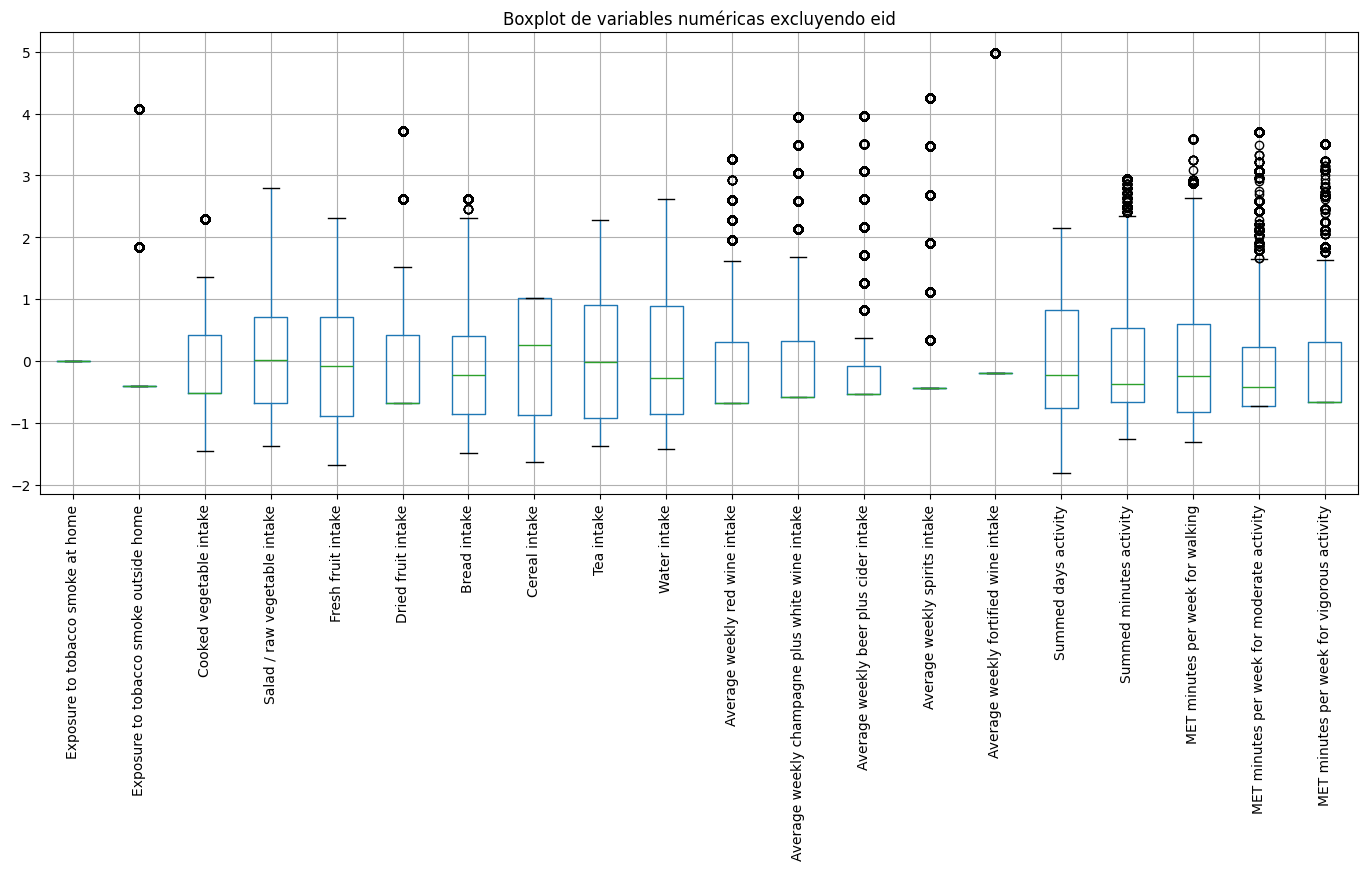

In [205]:
#Visualizar 
# Seleccionar todas las columnas excepto 'eid'
cols_to_plot = pheno_numeric_standard.drop(columns=['eid'])

# Boxplot 
cols_to_plot.boxplot(figsize=(17,6))
plt.title('Boxplot de variables numéricas excluyendo eid')
plt.xticks(rotation=90)
plt.show()

#### Categoricas

In [233]:
pheno_categoric_mapped

,eid,Disease,Condition,Current tobacco smoking,Past tobacco smoking,Smoking/smokers in household,Oily fish intake,Non-oily fish intake,Processed meat intake,Poultry intake,...,"Medication for pain relief, constipation, heartburn",Vitamin and mineral supplements,Mineral and other dietary supplements,Smoking status,Alcohol drinker status,Ever smoked,Ethnic background,IPAQ activity group,At or above moderate/vigorous recommendation,At or above moderate/vigorous/walking recommendation
28,1000298,Control,Control,No,Smoked occasionally,No,Once a week,Once a week,Less than once a week,Once a week,...,Aspirin,Multivitamins +/- minerals,Fish oil (including cod liver oil),Previous,Current,Yes,Chinese,high,Yes,Yes
75,1000767,IBD,IBD,No,I have never smoked,No,2-4 times a week,Once a week,Once a week,2-4 times a week,...,Ibuprofen (e.g. Nurofen),None of the above,Glucosamine,Never,Current,No,British,moderate,Yes,Yes
94,1000952,Control,Control,No,I have never smoked,"Yes, one household member smokes",Do not know,Never,Never,Never,...,None of the above,None of the above,None of the above,Never,Never,No,Indian,high,Yes,Yes
129,1001301,Control,Control,No,Smoked on most or all days,No,Less than once a week,Once a week,Less than once a week,2-4 times a week,...,None of the above,None of the above,None of the above,Previous,Current,Yes,Chinese,high,Yes,Yes
134,1001358,Control,Control,No,Just tried once or twice,No,Less than once a week,Less than once a week,2-4 times a week,2-4 times a week,...,None of the above,None of the above,None of the above,Never,Current,Yes,British,moderate,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502091,6021563,Control,Control,No,I have never smoked,No,Once a week,Once a week,Once a week,Less than once a week,...,Aspirin,None of the above,None of the above,Never,Current,No,British,high,Yes,Yes
502101,6021667,Control,Control,No,I have never smoked,"Yes, one household member smokes",Less than once a week,Once a week,Less than once a week,Once a week,...,None of the above,None of the above,None of the above,Never,Current,No,British,low,No,No
502123,6021888,Control,Control,No,I have never smoked,No,Once a week,Once a week,Less than once a week,Less than once a week,...,None of the above,None of the above,Fish oil (including cod liver oil),Never,Current,No,British,high,Yes,Yes
502126,6021914,Control,Control,No,I have never smoked,No,Less than once a week,Less than once a week,Less than once a week,Once a week,...,Paracetamol,Vitamin D,Calcium,Never,Current,No,British,high,Yes,Yes


In [234]:
# Ver valores unicos de cada columna
for col in pheno_categoric_mapped.columns:
    print(f"{col}: {pheno_categoric_mapped[col].unique()[:10]}")  # Muestra hasta 10 valores únicos por columna
    print("-" * 40)

eid: [1000298 1000767 1000952 1001301 1001358 1001662 1002418 1002677 1002943
 1002990]
----------------------------------------
Disease: ['Control' 'IBD' 'CD' 'UC']
----------------------------------------
Condition: ['Control' 'IBD']
----------------------------------------
Current tobacco smoking: ['No' 'Yes, on most or all days' 'Only occasionally'
 'Prefer not to answer']
----------------------------------------
Past tobacco smoking: ['Smoked occasionally' 'I have never smoked' 'Smoked on most or all days'
 'Just tried once or twice' 'Prefer not to answer']
----------------------------------------
Smoking/smokers in household: ['No' 'Yes, one household member smokes'
 'Yes, more than one household member smokes' 'Prefer not to answer']
----------------------------------------
Oily fish intake: ['Once a week' '2-4 times a week' 'Do not know' 'Less than once a week'
 'Never' '5-6 times a week' 'Once or more daily' 'Prefer not to answer']
----------------------------------------
Non-

##### Categoricas Nominales

In [236]:
# Variables categóricas nominales
pheno_nominal = [
    "eid",
    'Disease',
    'Condition',
    'Current tobacco smoking',
    'Past tobacco smoking',
    'Smoking/smokers in household',
    'Milk type used',
    'Spread type',
    'Bread type',
    'Cereal type',
    'Coffee type',
    'Alcohol usually taken with meals',
    'Never eat eggs, dairy, wheat, sugar',
    'Ethnic background',
    'Smoking status',
    'Alcohol drinker status',
    'Ever smoked',
    'Vascular/heart problems diagnosed by doctor',
    'Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor',
    'Medication for cholesterol, blood pressure, diabetes, or take exogenous hormones',
    'Medication for pain relief, constipation, heartburn',
    'Vitamin and mineral supplements',
    'Mineral and other dietary supplements',
    'Long-standing illness, disability or infirmity',
    'Ever had bowel cancer screening',
    'Diabetes diagnosed by doctor',
    'Cancer diagnosed by doctor',
    'Fractured/broken bones in last 5 years',
    'Other serious medical condition/disability diagnosed by doctor',
    'Taking other prescription medications',
    'At or above moderate/vigorous recommendation',
    'At or above moderate/vigorous/walking recommendation'
    
]

# Generar df de variables categoricas nominales
pheno_categorical_nominal = pheno_categoric_mapped[[col for col in pheno_nominal if col in pheno_categoric_mapped.columns]].copy()

In [237]:
pheno_categorical_nominal

,eid,Disease,Condition,Current tobacco smoking,Past tobacco smoking,Smoking/smokers in household,Milk type used,Spread type,Bread type,Cereal type,...,Mineral and other dietary supplements,"Long-standing illness, disability or infirmity",Ever had bowel cancer screening,Diabetes diagnosed by doctor,Cancer diagnosed by doctor,Fractured/broken bones in last 5 years,Other serious medical condition/disability diagnosed by doctor,Taking other prescription medications,At or above moderate/vigorous recommendation,At or above moderate/vigorous/walking recommendation
28,1000298,Control,Control,No,Smoked occasionally,No,Semi-skimmed,Never/rarely use spread,Wholemeal or wholegrain,Muesli,...,Fish oil (including cod liver oil),No,Yes,No,No,No,No,Yes - you will be asked about this later by an...,Yes,Yes
75,1000767,IBD,IBD,No,I have never smoked,No,Semi-skimmed,Other type of spread/margarine,Wholemeal or wholegrain,"Oat cereal (e.g. Ready Brek, porridge)",...,Glucosamine,No,No,No,No,No,No,No,Yes,Yes
94,1000952,Control,Control,No,I have never smoked,"Yes, one household member smokes",Semi-skimmed,Other type of spread/margarine,Wholemeal or wholegrain,"Oat cereal (e.g. Ready Brek, porridge)",...,None of the above,No,No,No,No,Yes,No,Yes - you will be asked about this later by an...,Yes,Yes
129,1001301,Control,Control,No,Smoked on most or all days,No,Semi-skimmed,Butter/spreadable butter,Wholemeal or wholegrain,"Oat cereal (e.g. Ready Brek, porridge)",...,None of the above,Yes,No,Yes,No,No,Do not know,Yes - you will be asked about this later by an...,Yes,Yes
134,1001358,Control,Control,No,Just tried once or twice,No,Semi-skimmed,Other type of spread/margarine,Wholemeal or wholegrain,Muesli,...,None of the above,No,No,No,No,Yes,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502091,6021563,Control,Control,No,I have never smoked,No,Skimmed,Other type of spread/margarine,White,"Other (e.g. Cornflakes, Frosties)",...,None of the above,No,No,No,No,No,No,Yes - you will be asked about this later by an...,Yes,Yes
502101,6021667,Control,Control,No,I have never smoked,"Yes, one household member smokes",Semi-skimmed,Butter/spreadable butter,Wholemeal or wholegrain,"Bran cereal (e.g. All Bran, Branflakes)",...,None of the above,No,No,No,No,No,No,No,No,No
502123,6021888,Control,Control,No,I have never smoked,No,Never/rarely have milk,Never/rarely use spread,Wholemeal or wholegrain,Muesli,...,Fish oil (including cod liver oil),No,No,No,No,Yes,No,No,Yes,Yes
502126,6021914,Control,Control,No,I have never smoked,No,Soya,Butter/spreadable butter,Wholemeal or wholegrain,"Oat cereal (e.g. Ready Brek, porridge)",...,Calcium,No,Yes,No,Yes - you will be asked about this later by an...,Yes,Yes - you will be asked about this later by an...,Yes - you will be asked about this later by an...,Yes,Yes


In [210]:
# Ver valores unicos de cada columna
for col in pheno_categorical_nominal.columns:
    print(f"{col}: {pheno_categorical_nominal[col].unique()[:10]}")  # Muestra hasta 10 valores únicos por columna
    print("-" * 40)

eid: [1000298 1000767 1000952 1001301 1001358 1001662 1002418 1002677 1002943
 1002990]
----------------------------------------
Disease: ['Control' 'IBD' 'CD' 'UC']
----------------------------------------
Condition: ['Control' 'IBD']
----------------------------------------
Current tobacco smoking: ['No' 'Yes, on most or all days' 'Only occasionally'
 'Prefer not to answer']
----------------------------------------
Past tobacco smoking: ['Smoked occasionally' 'I have never smoked' 'Smoked on most or all days'
 'Just tried once or twice' 'Prefer not to answer']
----------------------------------------
Smoking/smokers in household: ['No' 'Yes, one household member smokes'
 'Yes, more than one household member smokes' 'Prefer not to answer']
----------------------------------------
Milk type used: ['Semi-skimmed' 'Soya' 'Skimmed' 'Full cream' 'Never/rarely have milk'
 'Other type of milk' 'Prefer not to answer' 'Do not know']
----------------------------------------
Spread type: ['Never

In [238]:
# Columnas a excluir para crear dummies
exclude_cols = ['eid', 'Condition', 'Disease']

# Filtrar las columnas nominales para crear dummies (excluir las de la lista)
cols_to_dummify = [col for col in pheno_nominal if col not in exclude_cols]

# Inicializar DataFrame vacío con el mismo índice
pheno_dummies = pd.DataFrame(index=pheno_categorical_nominal.index)

# Crear dummies solo para las columnas filtradas
for col in cols_to_dummify:
    serie_filtrada = pheno_categorical_nominal[col].replace(
        {"Prefer not to answer": np.nan, "Do not know": np.nan}
    )
    dummies = pd.get_dummies(serie_filtrada, prefix=col, dummy_na=False)
    pheno_dummies = pd.concat([pheno_dummies, dummies], axis=1)

# Finalmente, añadir las columnas excluidas al DataFrame final
# 'eid' está en el índice, así que no es necesario añadirlo como columna
pheno_dummies['Condition'] = pheno_categorical_nominal['Condition']
pheno_dummies['Disease'] = pheno_categorical_nominal['Disease']
pheno_dummies['eid'] = pheno_categorical_nominal['eid']

pheno_dummies

,Current tobacco smoking_No,Current tobacco smoking_Only occasionally,"Current tobacco smoking_Yes, on most or all days",Past tobacco smoking_I have never smoked,Past tobacco smoking_Just tried once or twice,Past tobacco smoking_Smoked occasionally,Past tobacco smoking_Smoked on most or all days,Smoking/smokers in household_No,"Smoking/smokers in household_Yes, more than one household member smokes","Smoking/smokers in household_Yes, one household member smokes",...,Other serious medical condition/disability diagnosed by doctor_Yes - you will be asked about this later by an interviewer,Taking other prescription medications_No,Taking other prescription medications_Yes - you will be asked about this later by an interviewer,At or above moderate/vigorous recommendation_No,At or above moderate/vigorous recommendation_Yes,At or above moderate/vigorous/walking recommendation_No,At or above moderate/vigorous/walking recommendation_Yes,Condition,Disease,eid
28,True,False,False,False,False,True,False,True,False,False,...,False,False,True,False,True,False,True,Control,Control,1000298
75,True,False,False,True,False,False,False,True,False,False,...,False,True,False,False,True,False,True,IBD,IBD,1000767
94,True,False,False,True,False,False,False,False,False,True,...,False,False,True,False,True,False,True,Control,Control,1000952
129,True,False,False,False,False,False,True,True,False,False,...,False,False,True,False,True,False,True,Control,Control,1001301
134,True,False,False,False,True,False,False,True,False,False,...,False,True,False,True,False,False,True,Control,Control,1001358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502091,True,False,False,True,False,False,False,True,False,False,...,False,False,True,False,True,False,True,Control,Control,6021563
502101,True,False,False,True,False,False,False,False,False,True,...,False,True,False,True,False,True,False,Control,Control,6021667
502123,True,False,False,True,False,False,False,True,False,False,...,False,True,False,False,True,False,True,Control,Control,6021888
502126,True,False,False,True,False,False,False,True,False,False,...,True,False,True,False,True,False,True,Control,Control,6021914


In [239]:
# Ordenar las columnas de phenotypes_df, Disease de segunda columna
pheno_dummies= pheno_dummies[['eid', 'Disease',"Condition"] + [col for col in pheno_dummies.columns if col not in ['eid', 'Disease',"Condition"]]]
pheno_dummies

,eid,Disease,Condition,Current tobacco smoking_No,Current tobacco smoking_Only occasionally,"Current tobacco smoking_Yes, on most or all days",Past tobacco smoking_I have never smoked,Past tobacco smoking_Just tried once or twice,Past tobacco smoking_Smoked occasionally,Past tobacco smoking_Smoked on most or all days,...,Fractured/broken bones in last 5 years_No,Fractured/broken bones in last 5 years_Yes,Other serious medical condition/disability diagnosed by doctor_No,Other serious medical condition/disability diagnosed by doctor_Yes - you will be asked about this later by an interviewer,Taking other prescription medications_No,Taking other prescription medications_Yes - you will be asked about this later by an interviewer,At or above moderate/vigorous recommendation_No,At or above moderate/vigorous recommendation_Yes,At or above moderate/vigorous/walking recommendation_No,At or above moderate/vigorous/walking recommendation_Yes
28,1000298,Control,Control,True,False,False,False,False,True,False,...,True,False,True,False,False,True,False,True,False,True
75,1000767,IBD,IBD,True,False,False,True,False,False,False,...,True,False,True,False,True,False,False,True,False,True
94,1000952,Control,Control,True,False,False,True,False,False,False,...,False,True,True,False,False,True,False,True,False,True
129,1001301,Control,Control,True,False,False,False,False,False,True,...,True,False,False,False,False,True,False,True,False,True
134,1001358,Control,Control,True,False,False,False,True,False,False,...,False,True,True,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502091,6021563,Control,Control,True,False,False,True,False,False,False,...,True,False,True,False,False,True,False,True,False,True
502101,6021667,Control,Control,True,False,False,True,False,False,False,...,True,False,True,False,True,False,True,False,True,False
502123,6021888,Control,Control,True,False,False,True,False,False,False,...,False,True,True,False,True,False,False,True,False,True
502126,6021914,Control,Control,True,False,False,True,False,False,False,...,False,True,False,True,False,True,False,True,False,True


##### Categoricas Ordinales
 

In [230]:
# Variables categóricas ordinales
categorical_ordinal = [
    "eid",
    'Oily fish intake',
    'Non-oily fish intake',
    'Processed meat intake',
    'Poultry intake',
    'Beef intake',
    'Lamb/mutton intake',
    'Pork intake',
    'Cheese intake',
    'Salt added to food',
    'Hot drink temperature',
    'Major dietary changes in the last 5 years',
    'Variation in diet',
    'Alcohol intake frequency.',
    'Alcohol intake versus 10 years previously',
    'Overall health rating',
    'Falls in the last year',
    'Weight change compared with 1 year ago',
    'IPAQ activity group'
]


# Generar df de variables categoricas nominales
pheno_categorical_ordinal = pheno_categoric_mapped[[col for col in categorical_ordinal if col in pheno_categoric_mapped.columns]].copy()

pheno_categorical_ordinal



,eid,Oily fish intake,Non-oily fish intake,Processed meat intake,Poultry intake,Beef intake,Lamb/mutton intake,Pork intake,Cheese intake,Salt added to food,Hot drink temperature,Major dietary changes in the last 5 years,Variation in diet,Alcohol intake frequency.,Alcohol intake versus 10 years previously,Overall health rating,Falls in the last year,Weight change compared with 1 year ago,IPAQ activity group
28,1000298,Once a week,Once a week,Less than once a week,Once a week,Less than once a week,Less than once a week,Less than once a week,2-4 times a week,Never/rarely,Hot,No,Sometimes,Daily or almost daily,Less nowadays,Excellent,No falls,No - weigh about the same,high
75,1000767,2-4 times a week,Once a week,Once a week,2-4 times a week,Less than once a week,Less than once a week,Less than once a week,2-4 times a week,Never/rarely,Hot,"Yes, because of other reasons",Sometimes,Daily or almost daily,About the same,Excellent,No falls,No - weigh about the same,moderate
94,1000952,Do not know,Never,Never,Never,Never,Never,Never,Never,Always,Hot,No,Never/rarely,Never,Less nowadays,Fair,Only one fall,Yes - lost weight,high
129,1001301,Less than once a week,Once a week,Less than once a week,2-4 times a week,Less than once a week,Less than once a week,2-4 times a week,Less than once a week,Never/rarely,Hot,"Yes, because of illness",Sometimes,Special occasions only,About the same,Fair,No falls,No - weigh about the same,high
134,1001358,Less than once a week,Less than once a week,2-4 times a week,2-4 times a week,Less than once a week,Once a week,Never,2-4 times a week,Never/rarely,Hot,"Yes, because of other reasons",Never/rarely,Three or four times a week,Less nowadays,Excellent,No falls,No - weigh about the same,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502091,6021563,Once a week,Once a week,Once a week,Less than once a week,Never,Once a week,Once a week,Once a week,Sometimes,Warm,No,Sometimes,Once or twice a week,Less nowadays,Good,No falls,No - weigh about the same,high
502101,6021667,Less than once a week,Once a week,Less than once a week,Once a week,Once a week,Once a week,Less than once a week,2-4 times a week,Sometimes,Hot,No,Often,Daily or almost daily,About the same,Excellent,No falls,No - weigh about the same,low
502123,6021888,Once a week,Once a week,Less than once a week,Less than once a week,Never,Less than once a week,Never,Less than once a week,Never/rarely,Hot,No,Sometimes,Once or twice a week,More nowadays,Excellent,No falls,Yes - lost weight,high
502126,6021914,Less than once a week,Less than once a week,Less than once a week,Once a week,Less than once a week,Once a week,Once a week,2-4 times a week,Usually,Very hot,"Yes, because of other reasons",Sometimes,Daily or almost daily,More nowadays,Good,More than one fall,No - weigh about the same,high


In [224]:
# Ver valores unicos de cada columna
for col in pheno_categorical_ordinal.columns:
    print(f"{col}: {pheno_categorical_ordinal[col].unique()[:10]}")  # Muestra hasta 10 valores únicos por columna
    print("-" * 40)


eid: [1000298 1000767 1000952 1001301 1001358 1001662 1002418 1002677 1002943
 1002990]
----------------------------------------
Oily fish intake: ['Once a week' '2-4 times a week' 'Do not know' 'Less than once a week'
 'Never' '5-6 times a week' 'Once or more daily' 'Prefer not to answer']
----------------------------------------
Non-oily fish intake: ['Once a week' 'Never' 'Less than once a week' '2-4 times a week'
 'Do not know' '5-6 times a week' 'Prefer not to answer'
 'Once or more daily']
----------------------------------------
Processed meat intake: ['Less than once a week' 'Once a week' 'Never' '2-4 times a week'
 'Once or more daily' '5-6 times a week' 'Do not know'
 'Prefer not to answer']
----------------------------------------
Poultry intake: ['Once a week' '2-4 times a week' 'Never' 'Less than once a week'
 '5-6 times a week' 'Once or more daily' 'Do not know'
 'Prefer not to answer']
----------------------------------------
Beef intake: ['Less than once a week' 'Never'

In [231]:
categorical_mappings = {
    'Oily fish intake': {
        'Never': 0,
        'Less than once a week': 1,
        'Once a week': 2,
        '2-4 times a week': 3,
        '5-6 times a week': 4,
        'Once or more daily': 5,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Non-oily fish intake': {
        'Never': 0,
        'Less than once a week': 1,
        'Once a week': 2,
        '2-4 times a week': 3,
        '5-6 times a week': 4,
        'Once or more daily': 5,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Processed meat intake': {
        'Never': 0,
        'Less than once a week': 1,
        'Once a week': 2,
        '2-4 times a week': 3,
        '5-6 times a week': 4,
        'Once or more daily': 5,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Poultry intake': {
        'Never': 0,
        'Less than once a week': 1,
        'Once a week': 2,
        '2-4 times a week': 3,
        '5-6 times a week': 4,
        'Once or more daily': 5,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Beef intake': {
        'Never': 0,
        'Less than once a week': 1,
        'Once a week': 2,
        '2-4 times a week': 3,
        '5-6 times a week': 4,
        'Once or more daily': 5,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Lamb/mutton intake': {
        'Never': 0,
        'Less than once a week': 1,
        'Once a week': 2,
        '2-4 times a week': 3,
        '5-6 times a week': 4,
        'Once or more daily': 5,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Pork intake': {
        'Never': 0,
        'Less than once a week': 1,
        'Once a week': 2,
        '2-4 times a week': 3,
        '5-6 times a week': 4,
        'Once or more daily': 5,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Cheese intake': {
        'Never': 0,
        'Less than once a week': 1,
        'Once a week': 2,
        '2-4 times a week': 3,
        '5-6 times a week': 4,
        'Once or more daily': 5,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Salt added to food': {
        'Never/rarely': 0,
        'Sometimes': 1,
        'Usually': 2,
        'Always': 3,
        'Prefer not to answer': -2
    },
    'Hot drink temperature': {
        'Do not drink hot drinks': 0,
        'Warm': 1,
        'Hot': 2,
        'Very hot': 3,
        'Prefer not to answer': -2
    },
    'Major dietary changes in the last 5 years': {
        'No': 0,
        'Yes, because of illness': 1,
        'Yes, because of other reasons': 2,
        'Prefer not to answer': -2
    },
    'Variation in diet': {
        'Never/rarely': 0,
        'Sometimes': 1,
        'Often': 2,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Alcohol intake frequency.': {
        'Never': 0,
        'Special occasions only': 1,
        'One to three times a month': 2,
        'Once or twice a week': 3,
        'Three or four times a week': 4,
        'Daily or almost daily': 5,
        'Prefer not to answer': -2
    },
    'Alcohol intake versus 10 years previously': {
        'Less nowadays': 0,
        'About the same': 1,
        'More nowadays': 2,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'Overall health rating': {
        'Poor': 0,
        'Fair': 1,
        'Good': 2,
        'Excellent': 3,
        'Do not know': -1,
        'Prefer not to answer': -2
    },

    'Falls in the last year': {
        'No falls': 0,
        'Only one fall': 1,
        'More than one fall': 2,
        'Prefer not to answer': -2
    },
    'Weight change compared with 1 year ago': {
        'No - weigh about the same': 0,
        'Yes - lost weight': 1,
        'Yes - gained weight': 2,
        'Do not know': -1,
        'Prefer not to answer': -2
    },
    'IPAQ activity group': {
        'low': 0,
        'moderate': 1,
        'high': 2
    }
}




In [232]:
def map_and_replace_specials(df, mapping_dict):
    for col, mapping in mapping_dict.items():
        if col in df.columns:
            # Mapear valores según el diccionario
            df[col] = df[col].map(mapping)
            # Reemplazar -1 y -2 por NaN
            df[col] = df[col].replace({-1: np.nan, -2: np.nan})
    return df


pheno_ordinal_df= map_and_replace_specials(pheno_categorical_ordinal, categorical_mappings)
pheno_ordinal_df

,eid,Oily fish intake,Non-oily fish intake,Processed meat intake,Poultry intake,Beef intake,Lamb/mutton intake,Pork intake,Cheese intake,Salt added to food,Hot drink temperature,Major dietary changes in the last 5 years,Variation in diet,Alcohol intake frequency.,Alcohol intake versus 10 years previously,Overall health rating,Falls in the last year,Weight change compared with 1 year ago,IPAQ activity group
28,1000298,2.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,0.0,2.0,0.0,1.0,5.0,0.0,3.0,0.0,0.0,2
75,1000767,3.0,2.0,2.0,3.0,1.0,1.0,1.0,3.0,0.0,2.0,2.0,1.0,5.0,1.0,3.0,0.0,0.0,1
94,1000952,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2
129,1001301,1.0,2.0,1.0,3.0,1.0,1.0,3.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2
134,1001358,1.0,1.0,3.0,3.0,1.0,2.0,0.0,3.0,0.0,2.0,2.0,0.0,4.0,0.0,3.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502091,6021563,2.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,2
502101,6021667,1.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,1.0,2.0,0.0,2.0,5.0,1.0,3.0,0.0,0.0,0
502123,6021888,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,3.0,2.0,3.0,0.0,1.0,2
502126,6021914,1.0,1.0,1.0,2.0,1.0,2.0,2.0,3.0,2.0,3.0,2.0,1.0,5.0,2.0,2.0,2.0,0.0,2


## Dataset Assembly

merge
pheno_numeric_standard + pheno_dummies + pheno_ordinal_df


In [ ]:
pheno_numeric_standard['eid'] = pheno_numeric_standard['eid'].astype(str)
pheno_dummies['eid'] = pheno_dummies['eid'].astype(str)
pheno_ordinal_df['eid'] = pheno_ordinal_df['eid'].astype(str)

# Primer merge entre pheno_numeric_standard y pheno_dummies
df_merged = pd.merge(pheno_numeric_standard, pheno_dummies, on='eid', how='inner')

# Luego merge con pheno_ordinal_df
df_final = pd.merge(df_merged, pheno_ordinal_df, on='eid', how='inner')

# Ordenar las columnas de phenotypes_df, Disease de segunda columna
df_final = df_final[['eid', 'Disease', "Condition"] + [col for col in df_final.columns if col not in ['eid', 'Disease' , "Condition"]]]

# Si prefieres que 'eid' sea el índice
df_final = df_final.set_index('eid')

df_final

In [ ]:
#imputar por la media segun CONDICION
df_final_imputed = impute(df_final)

In [256]:
#Guardar en memo
df_final_imputed.to_csv(os.path.join(path_outputs, "phenotype_data_ready.csv"))

## Modelado

In [10]:
# Phenotypes
pheno_final= pd.read_csv("/Users/fjosesala/Documents/GitHub/Horizontal_UKB/phenotype/outputs/phenotype_data_ready.csv", sep="," , index_col= "eid")
# Eliminar la columna 'condicion'
pheno_final = pheno_final.drop('Disease', axis=1)
pheno_final

,Condition,Exposure to tobacco smoke at home,Exposure to tobacco smoke outside home,Cooked vegetable intake,Salad / raw vegetable intake,Fresh fruit intake,Dried fruit intake,Bread intake,Cereal intake,Tea intake,...,Salt added to food,Hot drink temperature,Major dietary changes in the last 5 years,Variation in diet,Alcohol intake frequency.,Alcohol intake versus 10 years previously,Overall health rating,Falls in the last year,Weight change compared with 1 year ago,IPAQ activity group
eid,,,,,,,,,,,,,,,,,,,,,
1000298,Control,0.0,-0.396898,-0.522908,0.715575,0.715098,0.417313,-0.223232,1.011390,-0.467053,...,0.0,2.0,0.0,1.0,5.0,0.0,3.0,0.0,0.0,2
1000767,IBD,0.0,-0.396898,0.416371,0.715575,-0.085402,-0.682296,-0.223232,-0.120292,-0.923759,...,0.0,2.0,2.0,1.0,5.0,1.0,3.0,0.0,0.0,1
1001301,Control,0.0,-0.396898,0.416371,-1.025108,-1.286154,-0.132491,-1.487049,-1.440588,-0.923759,...,0.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2
1001358,Control,0.0,1.840566,0.416371,-0.676971,-0.085402,-0.682296,1.356539,-0.497519,0.903065,...,0.0,2.0,2.0,0.0,4.0,0.0,3.0,0.0,0.0,1
1001662,Control,0.0,1.840566,-0.522908,-1.373244,-1.686404,-0.682296,-1.487049,0.256935,-0.010347,...,0.0,2.0,2.0,1.0,4.0,1.0,3.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021563,Control,0.0,-0.396898,0.416371,-0.676971,-0.085402,-0.682296,-0.855141,1.011390,-0.010347,...,1.0,1.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,2
6021667,Control,0.0,-0.396898,-0.522908,0.019302,-0.885903,-0.682296,0.092722,1.011390,-0.467053,...,1.0,2.0,0.0,2.0,5.0,1.0,3.0,0.0,0.0,0
6021888,Control,0.0,-0.396898,2.294930,0.715575,0.715098,0.417313,-0.223232,1.011390,-1.380465,...,0.0,2.0,0.0,1.0,3.0,2.0,3.0,0.0,1.0,2


In [282]:
pheno_final.dtypes

Condition                                     object
Exposure to tobacco smoke at home            float64
Exposure to tobacco smoke outside home       float64
Cooked vegetable intake                      float64
Salad / raw vegetable intake                 float64
                                              ...   
Alcohol intake versus 10 years previously    float64
Overall health rating                        float64
Falls in the last year                       float64
Weight change compared with 1 year ago       float64
IPAQ activity group                            int64
Length: 163, dtype: object

In [11]:
#undersampling


# Separar los datos
control = pheno_final[pheno_final['Condition'] == 'Control']
ibd = pheno_final[pheno_final['Condition'] == 'IBD']

# Ver cuántos casos IBD hay
print(f"Casos IBD: {len(ibd)}")

# Undersample de controles para igualar el número de IBD
control_downsampled = control.sample(n=len(ibd), random_state=42)

# Unir ambos subconjuntos
balanced_df = pd.concat([control_downsampled, ibd])

# Mezclar aleatoriamente
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificación rápida
print(balanced_df['Condition'].value_counts())


Casos IBD: 3093
Condition
IBD        3093
Control    3093
Name: count, dtype: int64


In [18]:
# Separar X e y
X = balanced_df.drop(columns='Condition')
y = balanced_df['Condition']

# Dividir en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Lasso

In [6]:
#Regresion lasso 

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X = pheno_final.drop('Condition', axis=1)
y = pheno_final['Condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

ValueError: could not convert string to float: 'Control'

### Random Forest


In [ ]:
shap.initjs()

In [ ]:
# Entrenar modelo
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
clf.fit(X_train, y_train)

# Predicción
y_pred = clf.predict(X_test)

# Evaluar
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       940
           1       0.71      0.70      0.71       916

    accuracy                           0.71      1856
   macro avg       0.71      0.71      0.71      1856
weighted avg       0.71      0.71      0.71      1856



In [86]:
importances = clf.feature_importances_

# Crear un DataFrame para verlo mejor
importances_df = pd.DataFrame({'variable': X.columns, 'importancia': importances})

# Ordenar de mayor a menor
importances_df = importances_df.sort_values(by='importancia', ascending=False)
importances_df

,variable,importancia
128,Ever had bowel cancer screening_No,0.034466
129,Ever had bowel cancer screening_Yes,0.032533
139,Taking other prescription medications_Yes - yo...,0.025421
158,Overall health rating,0.024808
6,Bread intake,0.024525
...,...,...
67,Ethnic background_Bangladeshi,0.000048
66,Ethnic background_Asian or Asian British,0.000004
77,Ethnic background_White and Black African,0.000000
63,Ethnic background_Any other Black background,0.000000


In [87]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)

In [88]:
X_test = X_test.apply(pd.to_numeric, errors='coerce')

/Users/fjosesala/Documents/GitHub/Horizontal_UKB/.venv/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


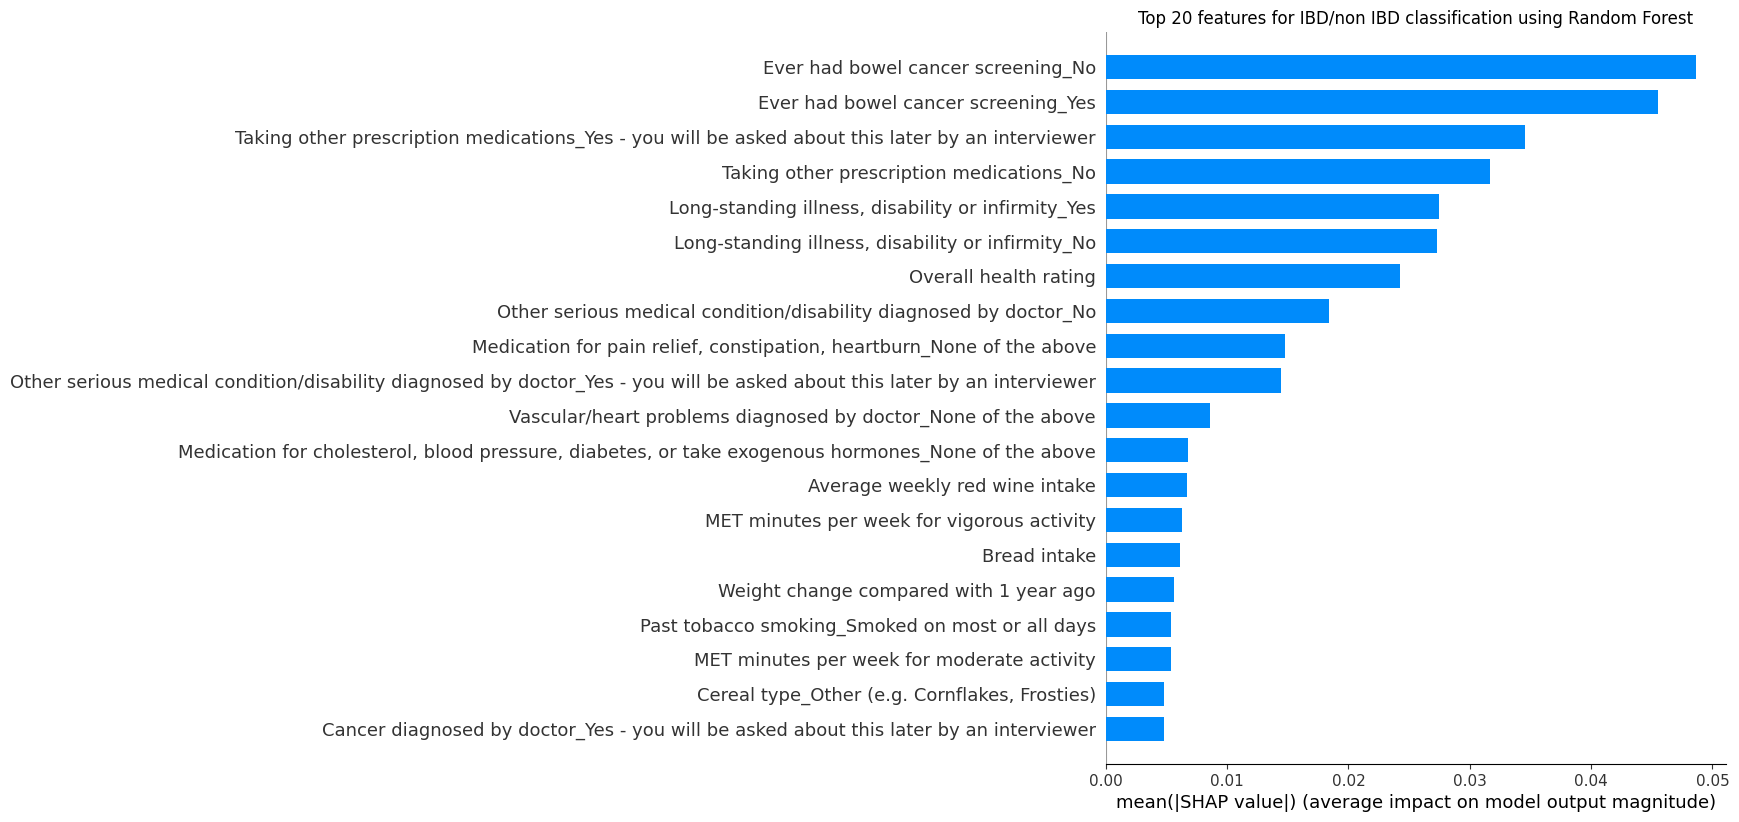

In [97]:
# Crear el plot SHAP (summary bar plot)
shap.summary_plot(shap_values[:,:,1], X_test, show=False, plot_type="bar", max_display=20)
# Agregar título con matplotlib
plt.title("Top 20 features for IBD/non IBD classification using Random Forest")
# Mostrar la figura con el título
plt.show()

/Users/fjosesala/Documents/GitHub/Horizontal_UKB/.venv/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


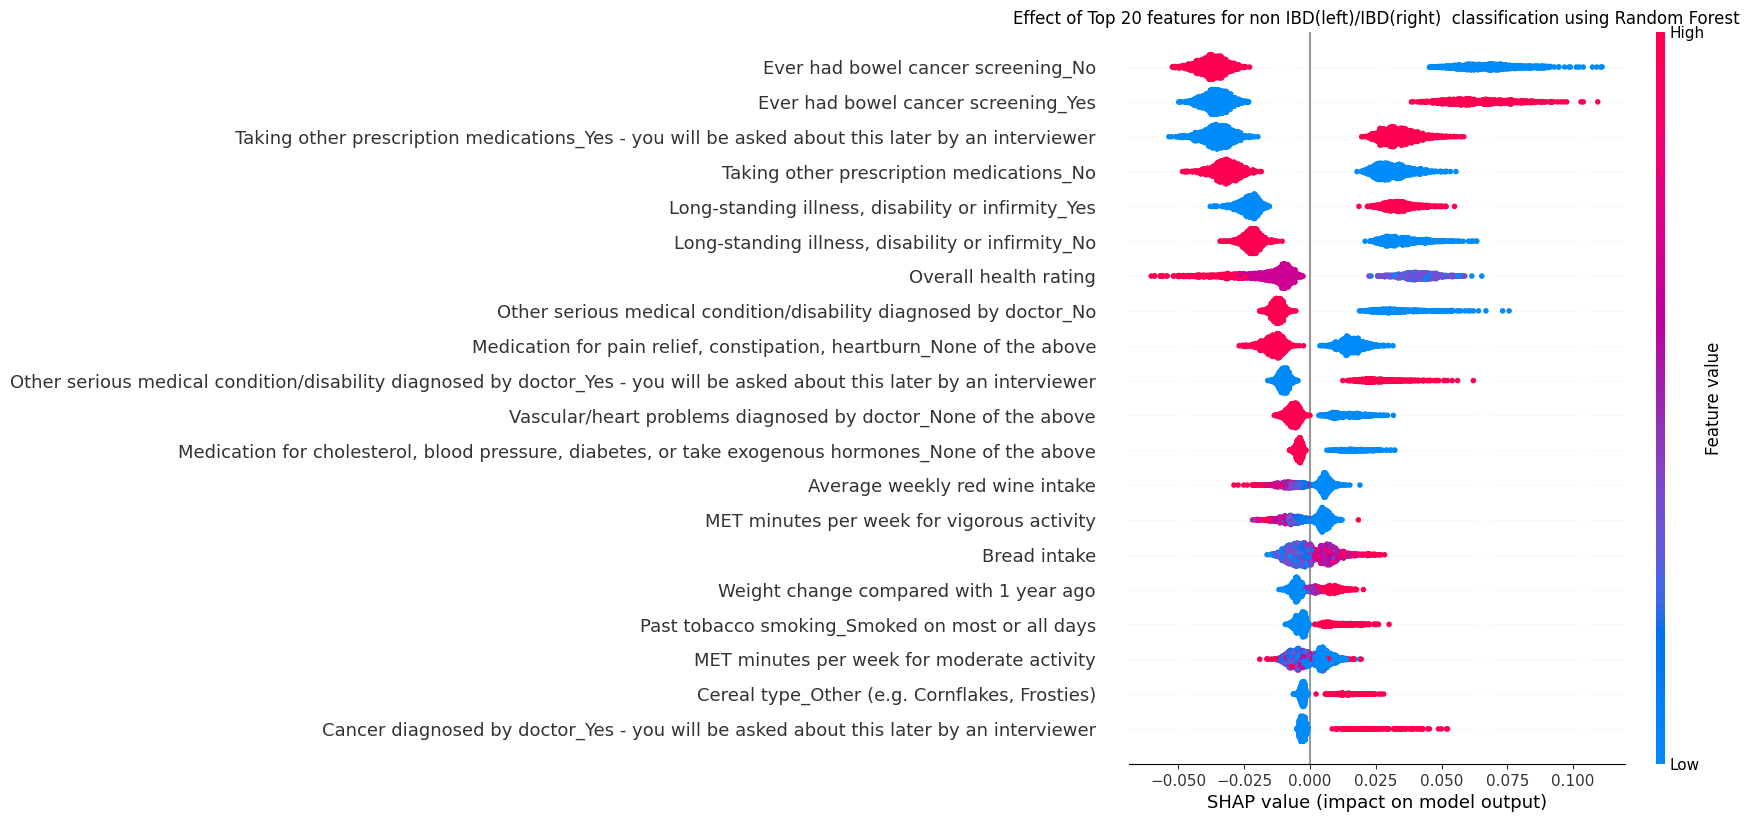

In [99]:
shap.summary_plot(shap_values[:,:,1], X_test, show=False) #ibd
plt.title("Effect of Top 20 features for non IBD(left)/IBD(right)  classification using Random Forest")
plt.show()

In [96]:
#importancia de las variables

importances = clf.feature_importances_
importances_df = pd.DataFrame({'variable': X.columns, 'importancia': importances})
importances_df = importances_df.sort_values(by='importancia', ascending=False)
top_varsRF = importances_df

top_varsRF

,variable,importancia
128,Ever had bowel cancer screening_No,0.034466
129,Ever had bowel cancer screening_Yes,0.032533
139,Taking other prescription medications_Yes - yo...,0.025421
158,Overall health rating,0.024808
6,Bread intake,0.024525
...,...,...
67,Ethnic background_Bangladeshi,0.000048
66,Ethnic background_Asian or Asian British,0.000004
77,Ethnic background_White and Black African,0.000000
63,Ethnic background_Any other Black background,0.000000


### XGBoost

In [ ]:
#Passar clase a label numerico
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#Crear modelo 
XGBmodel = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_stimators=1000)
XGBmodel.fit(X_train, y_train)

/Users/fjosesala/Documents/GitHub/Horizontal_UKB/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_stimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, n_stimators=1000, ...)

In [57]:
# Realizamos predicciones en el conjunto de prueba
y_pred = XGBmodel.predict(X_test)

# Evaluamos el modelo
accuracy = XGBmodel.score(X_test, y_test)
print('Precisión:', accuracy)


Precisión: 0.6939655172413793


/Users/fjosesala/Documents/GitHub/Horizontal_UKB/.venv/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


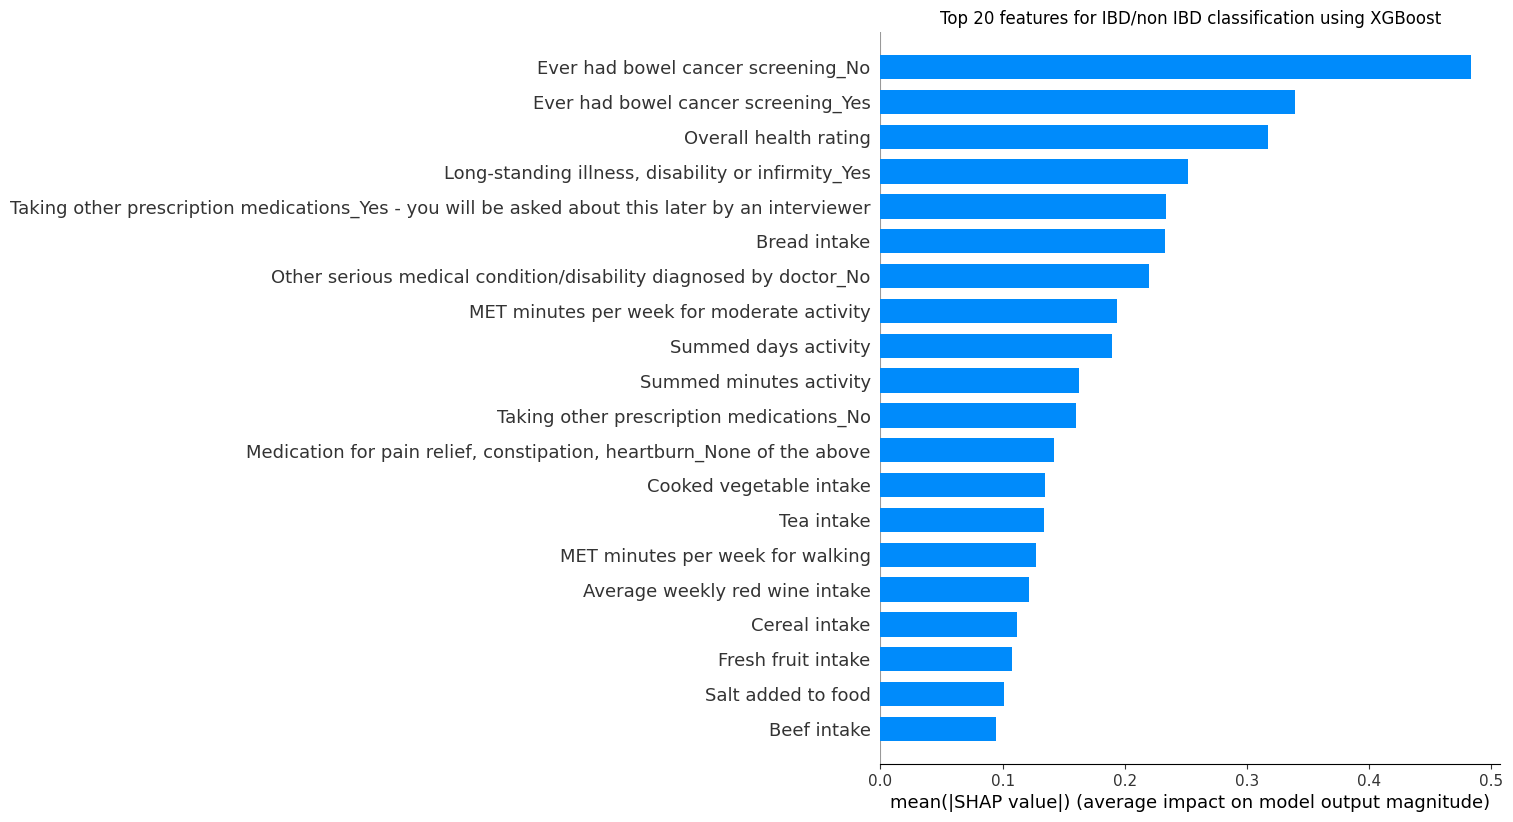

In [ ]:
X_test = X_test.apply(pd.to_numeric, errors='coerce')
explainer2 = shap.Explainer(XGBmodel)
shap_values2 = explainer2(X_test)
# Crear el plot SHAP (summary bar plot)
shap.summary_plot(shap_values2, X_test, plot_type="bar", max_display=20, show=False)
# Agregar título con matplotlib
plt.title("Top 20 features for IBD/non IBD classification using XGBoost")
# Mostrar la figura con el título
plt.show()

/Users/fjosesala/Documents/GitHub/Horizontal_UKB/.venv/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


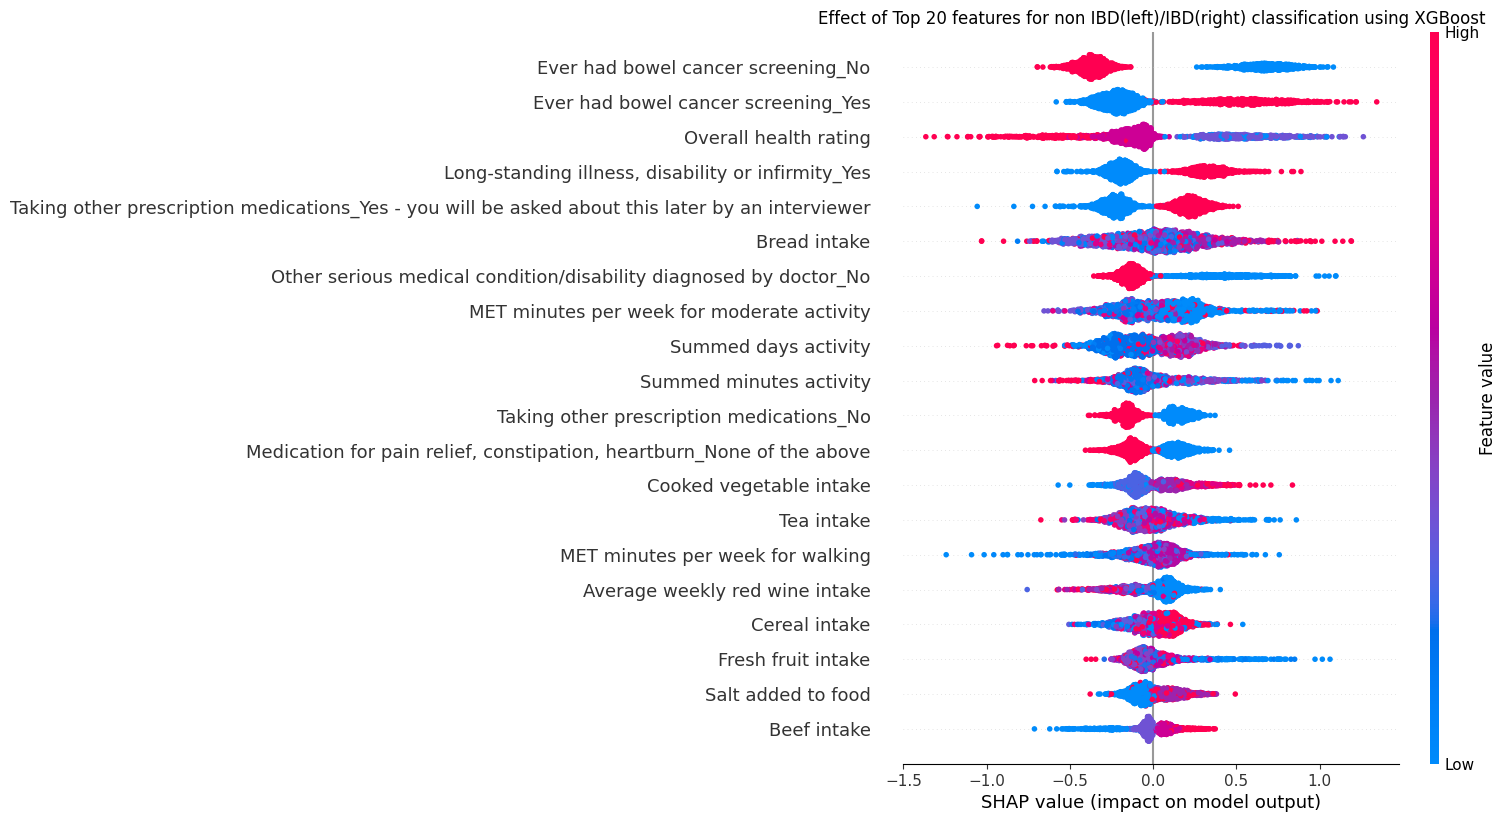

In [98]:
#Prob de tener ibd. valores rojos a la izq reducen la prob de tener ibd
# Crear el plot SHAP (summary bar plot)
shap.summary_plot(shap_values2, X_test, plot_type="dot", max_display=20, show=False)
# Agregar título con matplotlib
plt.title("Effect of Top 20 features for non IBD(left)/IBD(right) classification using XGBoost")
# Mostrar la figura con el título
plt.show()

In [71]:
# Obtener la importancia de cada variable del modelo XGBoost MEDIANTE SHAP - MAS CONFIABLE

# Calcular la media del valor absoluto de SHAP por variable
shap_importance = np.abs(shap_values2.values).mean(axis=0)

# Crear un DataFrame con nombres de variables
shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': shap_importance
})

# Ordenar por importancia
shap_df = shap_df.sort_values(by='mean_abs_shap', ascending=False)

# Ver top 20 variables más importantes
top_varsXGB = shap_df
print(top_varsXGB)

                                               feature  mean_abs_shap
128                 Ever had bowel cancer screening_No       0.483136
129                Ever had bowel cancer screening_Yes       0.339190
158                              Overall health rating       0.317388
127  Long-standing illness, disability or infirmity...       0.251757
139  Taking other prescription medications_Yes - yo...       0.233838
..                                                 ...            ...
62        Ethnic background_Any other Asian background       0.000000
111  Vitamin and mineral supplements_Folic acid or ...       0.000000
118          Vitamin and mineral supplements_Vitamin E       0.000000
124     Mineral and other dietary supplements_Selenium       0.000000
0                    Exposure to tobacco smoke at home       0.000000

[162 rows x 2 columns]
